In [19]:
import torch
import torchaudio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
import soundfile

In [47]:
from torch import nn
from torch.nn import functional as F

In [53]:
from pytorch_lightning.metrics import functional

## Step1: Loading the data

In [3]:
datapath = Path("data\ESC-50-master\ESC-50-master")

In [4]:
datapath.exists()

True

In [5]:
csv = pd.read_csv(datapath / Path("meta/esc50.csv"))

In [6]:
csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [12]:
x, sr = torchaudio.load(datapath / 'audio' / csv.iloc[0, 0], normalization=True)

In [13]:
x.shape

torch.Size([1, 220500])

In [14]:
torchaudio.transforms.Resample(orig_freq=sr, new_freq=8000)(x).shape

torch.Size([1, 40000])

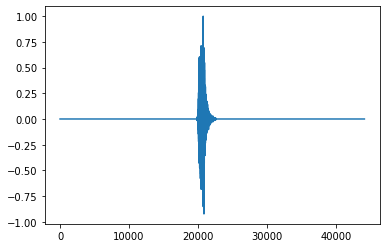

In [25]:
plt.plot(x[0, ::5])

In [16]:
h = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(x)

In [17]:
h.shape

torch.Size([1, 128, 1103])

In [23]:
h = torchaudio.transforms.AmplitudeToDB()(h)

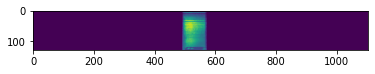

In [24]:
plt.imshow(h[0])

In [37]:
class ESC50Dataset(torch.utils.data.Dataset):
    def __init__(self, path: Path = Path("data\ESC-50-master\ESC-50-master"), 
                 sample_rate: int = 8000,
                 folds = [1]):
        # Load CSV & initialize all torchaudio.transforms
        # Resample --> MelSpectrogram --> AmplitudeToDB     
        self.path = path
        self.csv = pd.read_csv(path / Path("meta/esc50.csv"))
        self.csv = self.csv[self.csv["fold"].isin(folds)]
        self.resample = torchaudio.transforms.Resample(
            orig_freq=44100, new_freq=sample_rate
        )
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)
        self.db = torchaudio.transforms.AmplitudeToDB()

    def __getitem__(self, index):
        # Returns (xb, yb) pair
        row = self.csv.iloc[index]
        wav, _ = torchaudio.load(self.path / "audio" / row["filename"])
        label = row["target"]
        xb = self.db(self.melspec(self.resample(wav)))
        return xb, label

    def __len__(self):
        # Return Length
        return len(self.csv)

In [38]:
train_data = ESC50Dataset(folds=[1])

In [39]:
for xb, yb in train_data:
    break

In [40]:
xb.shape

torch.Size([1, 128, 201])

In [41]:
yb

0

In [42]:
train_data = ESC50Dataset(folds=[1])
val_data = ESC50Dataset(folds=[2])
test_data = ESC50Dataset(folds=[3])

In [61]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=0)

In [62]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8, num_workers=0)

In [63]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, num_workers=0)

## Building the model

In [49]:
class AudioNet(pl.LightningModule):
    
    def __init__(self, n_classes = 50, base_filters = 32):
        super().__init__()
        self.conv1 = nn.Conv2d(1, base_filters, 11, padding=5)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(base_filters, base_filters * 2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters * 2)
        self.conv4 = nn.Conv2d(base_filters * 2, base_filters * 4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filters * 4)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(base_filters * 4, n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.fc1(x[:, :, 0, 0])
        return x
    
    def training_step(self, batch, batch_idx):
        # Very simple training loop
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.argmax(y_hat, dim=1)
        acc = functional.accuracy(y_hat, y)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return acc
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [48]:
pl.seed_everything(0)

Global seed set to 0


0

In [50]:
audionet = AudioNet()
xb, yb = next(iter(train_loader))
audionet(xb).shape

torch.Size([8, 50])

In [65]:
trainer = pl.Trainer(max_epochs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [66]:
trainer.fit(audionet, train_loader, val_loader)

                                                              
   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 3.9 K 
1  | bn1   | BatchNorm2d | 64    
2  | conv2 | Conv2d      | 9.2 K 
3  | bn2   | BatchNorm2d | 64    
4  | pool1 | MaxPool2d   | 0     
5  | conv3 | Conv2d      | 18.5 K
6  | bn3   | BatchNorm2d | 128   
7  | conv4 | Conv2d      | 73.9 K
8  | bn4   | BatchNorm2d | 256   
9  | pool2 | MaxPool2d   | 0     
10 | fc1   | Linear      | 6.5 K 
---------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.450     Total estimated model params size (MB)
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]D:\G\miniconda\envs\d2l\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4